In [1]:
import pandas as pd

# Load data
file_path = "//content/individual+household+electric+power+consumption.zip"
df = pd.read_csv(
    file_path,
    sep=';',
    parse_dates={'DateTime': ['Date', 'Time']},
    infer_datetime_format=True,
    na_values=['?'],
    low_memory=False
)

# Convert types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Drop rows with missing values
df.dropna(inplace=True)

# Set datetime index
df.set_index('DateTime', inplace=True)

# Keep only useful columns
df = df[['Global_active_power']]

print(df.head())


<ipython-input-1-98bed57f1bb0>:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
<ipython-input-1-98bed57f1bb0>:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
<ipython-input-1-98bed57f1bb0>:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


                     Global_active_power
DateTime                                
2006-12-16 17:24:00                4.216
2006-12-16 17:25:00                5.360
2006-12-16 17:26:00                5.374
2006-12-16 17:27:00                5.388
2006-12-16 17:28:00                3.666


In [3]:
# Resample to hourly average (optional, helps smoothen data)
df_hourly = df.resample('H').mean()

# Drop any remaining NaNs after resampling
df_hourly.dropna(inplace=True)

# Feature: Hour, Day, Weekday
df_hourly['hour'] = df_hourly.index.hour
df_hourly['day'] = df_hourly.index.day
df_hourly['weekday'] = df_hourly.index.weekday

# Feature: Rolling mean (3-hour window)
df_hourly['rolling_mean_3h'] = df_hourly['Global_active_power'].rolling(window=3).mean().shift(1)

# Feature: Lag features (previous time steps)
df_hourly['lag_1'] = df_hourly['Global_active_power'].shift(1)
df_hourly['lag_2'] = df_hourly['Global_active_power'].shift(2)
df_hourly['lag_24'] = df_hourly['Global_active_power'].shift(24)  # same hour yesterday

# Drop rows with NaNs after creating lag features
df_hourly.dropna(inplace=True)

print(df_hourly.head())


                     Global_active_power  hour  day  weekday  rolling_mean_3h  \
DateTime                                                                        
2006-12-17 17:00:00             3.406767    17   17        6         2.801356   
2006-12-17 18:00:00             3.697100    18   17        6         3.239400   
2006-12-17 19:00:00             2.908400    19   17        6         3.476633   
2006-12-17 20:00:00             3.361500    20   17        6         3.337422   
2006-12-17 21:00:00             3.040767    21   17        6         3.322333   

                        lag_1     lag_2    lag_24  
DateTime                                           
2006-12-17 17:00:00  3.326033  2.985400  4.222889  
2006-12-17 18:00:00  3.406767  3.326033  3.632200  
2006-12-17 19:00:00  3.697100  3.406767  3.400233  
2006-12-17 20:00:00  2.908400  3.697100  3.268567  
2006-12-17 21:00:00  3.361500  2.908400  3.056467  


<ipython-input-3-5173edc5fe94>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean()


In [4]:
pip install xgboost


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

# Define features and target
X = df_hourly.drop('Global_active_power', axis=1)
y = df_hourly['Global_active_power']

# Split into train and test (time series-aware split: no shuffle!)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train XGBoost Regressor
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")


RMSE: 0.486
MAE: 0.338


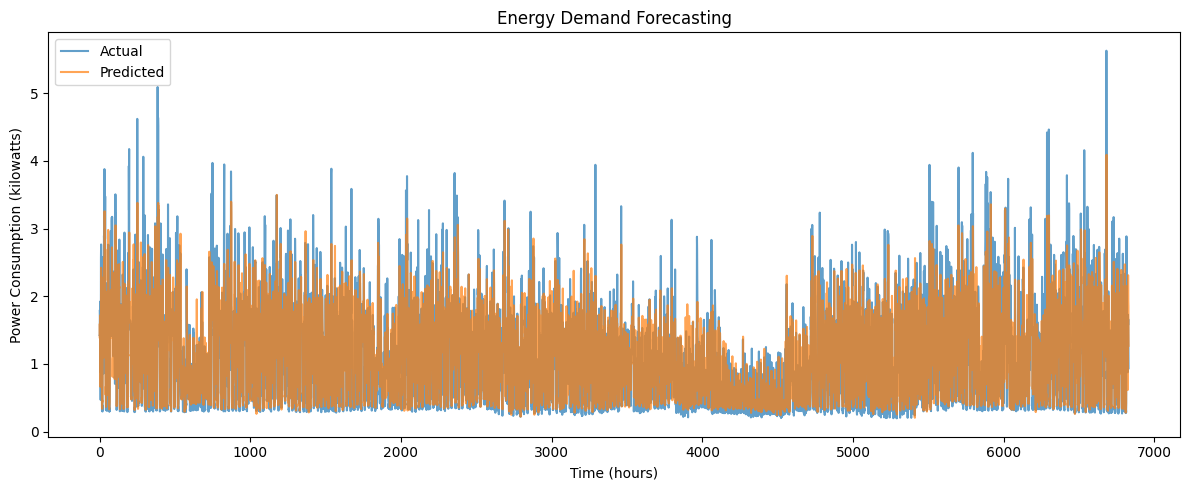

In [6]:
# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title("Energy Demand Forecasting")
plt.xlabel("Time (hours)")
plt.ylabel("Power Consumption (kilowatts)")
plt.legend()
plt.tight_layout()
plt.show()


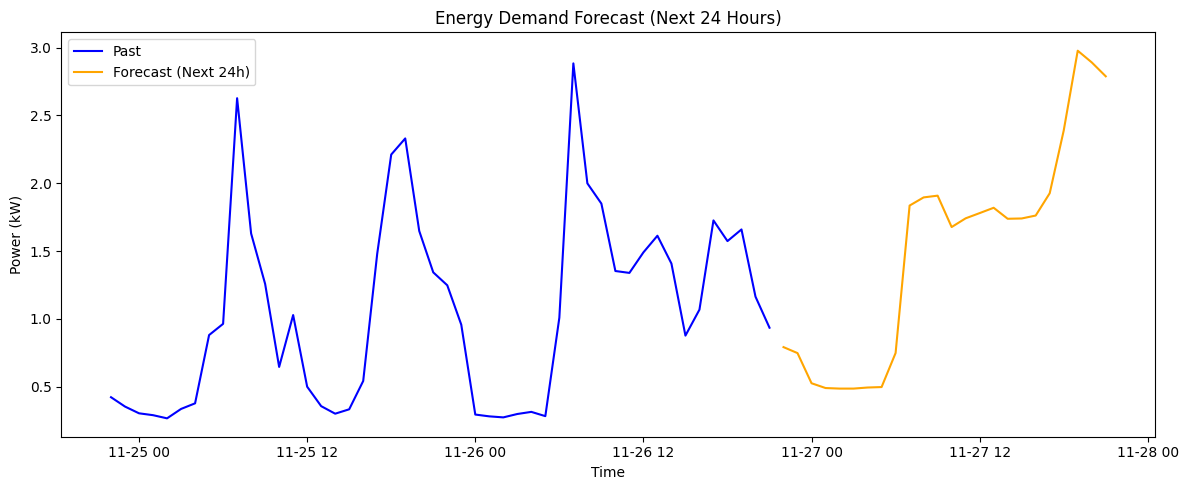

In [7]:
import datetime

# Number of steps to predict
future_steps = 24

# Create a copy of the last known data to begin forecasting
forecast_data = df_hourly.copy()

# Store predictions
future_predictions = []

for i in range(future_steps):
    last_row = forecast_data.iloc[-1:].copy()
    next_index = last_row.index[0] + pd.Timedelta(hours=1)

    # Create new row with next timestamp
    new_row = pd.DataFrame(index=[next_index])

    # Hour, day, weekday
    new_row['hour'] = next_index.hour
    new_row['day'] = next_index.day
    new_row['weekday'] = next_index.weekday()

    # Lag features
    new_row['lag_1'] = forecast_data['Global_active_power'].iloc[-1]
    new_row['lag_2'] = forecast_data['Global_active_power'].iloc[-2]
    new_row['lag_24'] = forecast_data['Global_active_power'].iloc[-24] if len(forecast_data) >= 24 else new_row['lag_1']

    # Rolling mean
    new_row['rolling_mean_3h'] = forecast_data['Global_active_power'].iloc[-3:].mean()

    # Predict
    x_input = new_row[['hour', 'day', 'weekday', 'rolling_mean_3h', 'lag_1', 'lag_2', 'lag_24']]
    prediction = model.predict(x_input)[0]

    # Store prediction
    new_row['Global_active_power'] = prediction
    forecast_data = pd.concat([forecast_data, new_row])
    future_predictions.append((next_index, prediction))

# Convert to DataFrame
future_df = pd.DataFrame(future_predictions, columns=['DateTime', 'Forecasted_Power'])
future_df.set_index('DateTime', inplace=True)

# Plot future forecast
plt.figure(figsize=(12, 5))
plt.plot(df_hourly['Global_active_power'].iloc[-48:], label='Past', color='blue')
plt.plot(future_df['Forecasted_Power'], label='Forecast (Next 24h)', color='orange')
plt.title("Energy Demand Forecast (Next 24 Hours)")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import xgboost as xgb

# Define time series split
tscv = TimeSeriesSplit(n_splits=3)

# Parameter grid (same or improved)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

# RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

# XGBoost model
model = xgb.XGBRegressor()

# Randomized Search with TimeSeriesSplit
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    cv=tscv,
    scoring=rmse_scorer,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)

# Evaluate best model
best_model_ts = random_search.best_estimator_
y_pred_ts = best_model_ts.predict(X_test)

# Calculate RMSE without the 'squared' argument, then take the square root
mse_ts = mean_squared_error(y_test, y_pred_ts)  # Calculate MSE
rmse_ts = np.sqrt(mse_ts)                      # Take the square root to get RMSE

mae_ts = mean_absolute_error(y_test, y_pred_ts)

print("Best Parameters (TimeSeriesSplit):", random_search.best_params_)
print(f"RMSE (TSCV): {rmse_ts:.3f}")
print(f"MAE (TSCV): {mae_ts:.3f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Best Parameters (TimeSeriesSplit): {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
RMSE (TSCV): 0.487
MAE (TSCV): 0.340


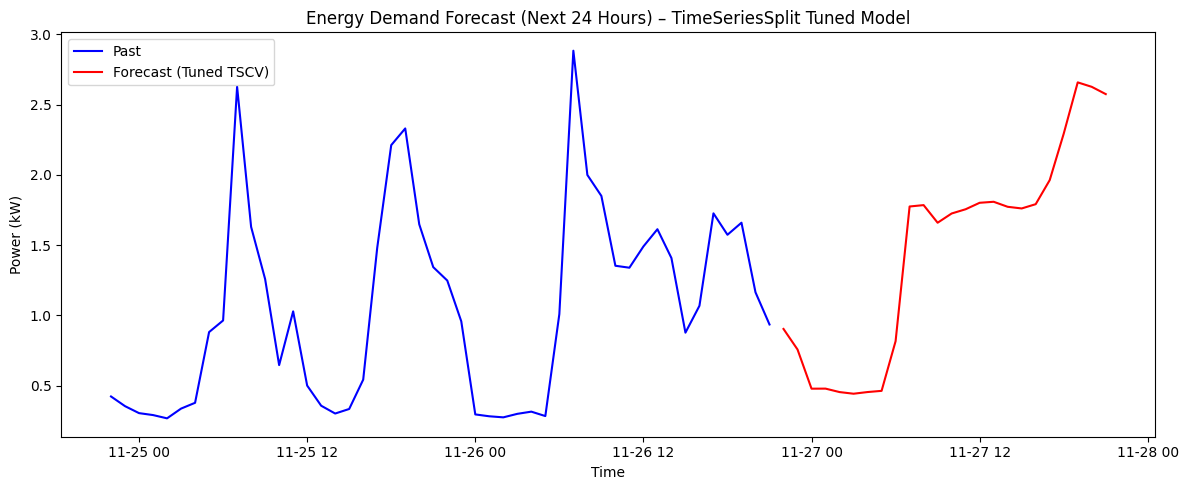

In [12]:
# Start from the latest known data
forecast_data = df_hourly.copy()
future_predictions = []
future_steps = 24

for i in range(future_steps):
    last_row = forecast_data.iloc[-1:].copy()
    next_index = last_row.index[0] + pd.Timedelta(hours=1)

    # Prepare new row for prediction
    new_row = pd.DataFrame(index=[next_index])
    new_row['hour'] = next_index.hour
    new_row['day'] = next_index.day
    new_row['weekday'] = next_index.weekday()

    new_row['lag_1'] = forecast_data['Global_active_power'].iloc[-1]
    new_row['lag_2'] = forecast_data['Global_active_power'].iloc[-2]
    new_row['lag_24'] = forecast_data['Global_active_power'].iloc[-24] if len(forecast_data) >= 24 else new_row['lag_1']
    new_row['rolling_mean_3h'] = forecast_data['Global_active_power'].iloc[-3:].mean()

    # Predict with TimeSeriesSplit-tuned model
    x_input = new_row[['hour', 'day', 'weekday', 'rolling_mean_3h', 'lag_1', 'lag_2', 'lag_24']]
    prediction = best_model_ts.predict(x_input)[0]

    new_row['Global_active_power'] = prediction
    forecast_data = pd.concat([forecast_data, new_row])
    future_predictions.append((next_index, prediction))

# Convert results to DataFrame
future_df_ts = pd.DataFrame(future_predictions, columns=['DateTime', 'Forecasted_Power'])
future_df_ts.set_index('DateTime', inplace=True)

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(df_hourly['Global_active_power'].iloc[-48:], label='Past', color='blue')
plt.plot(future_df_ts['Forecasted_Power'], label='Forecast (Tuned TSCV)', color='red')
plt.title("Energy Demand Forecast (Next 24 Hours) – TimeSeriesSplit Tuned Model")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.legend()
plt.tight_layout()
plt.show()
